<a href="https://colab.research.google.com/github/Mohdsyeed/Machine_Learning_Projects/blob/main/Avocado_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Hey ML fam! Up for a new project? Today, we'll be predicting some avocado prices! It is a well-known fact that Millenials LOVE Avocado Toast. It's also a well-known fact that all Millenials live in their parent's basements.

Clearly, they aren't buying a home because they are buying too much Avocado Toast!

But maybe there's hope… if a Millenial could find a city with cheap avocados, they could live out the Millenial American Dream.

# About Data
This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. Here's how the [Hass Avocado Board describes the data on their website:](https://hassavocadoboard.com/)

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar, and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLUs) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

# Evaluation
This project is fairly simple, we'll use some measures like RMSE and similar to these metrics.

As this is just a dataset (And not a Kaggle competition), we'll take 0.2% of our data as our test set, and the rest shall be our training set.

The Dataset / Kaggle Link: https://www.kaggle.com/datasets/neuromusic/avocado-prices

In [36]:
# Importing neccasary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import Pre-Processing Libs
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

print("Import Completed")

Import Completed


In [37]:
# Load the data
df_avocados = pd.read_csv("/content/avocado.csv", parse_dates=True)

# Datetime Settings
df_avocados['Date'] =pd.to_datetime(df_avocados.Date)
df_avocados.sort_values(by=['Date'], inplace=True, ascending=True)

# Reset Index
df_avocados = df_avocados.reset_index()

# Remove Unnamed: 0 Column as well as index column
df_avocados = df_avocados.drop(columns=["Unnamed: 0", "index"])

# Change 4046, 4225, 4770 to their respective values
df_avocados = df_avocados.rename(columns={"4046":"Small Hass", "4225":"Large Hass", "4770":"XLarge Hass"})

# Move the Average Price column to the last end
df_avocados = df_avocados[['Date', 'Total Volume', 'Small Hass', 'Large Hass',
       'XLarge Hass', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags',
       'type', 'year', 'region', 'AveragePrice']]

In [38]:
# First 5 rows of the data
df_avocados.head()

,Date,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePrice
0,2015-01-04,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,1.75
1,2015-01-04,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,1.49
2,2015-01-04,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,1.68
3,2015-01-04,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,1.52
4,2015-01-04,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,1.64


# Exploratory Data Analysis
We'll cover the following things:

*   Some *information* about the dataset
*   Some *description* of the dataset
*   Check *null* values
*   Some PLOTS:

Distribution of Price (i.e AveragePrice)

Distribution of Volumne (i.e Total Volume), then also check for per_annum.

Count of **Hasses**

Count of **Bags**

Count of **Type**

Count of **Year**

Count of **Region**


In [39]:
# Information
df_avocados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   Total Volume  18249 non-null  float64       
 2   Small Hass    18249 non-null  float64       
 3   Large Hass    18249 non-null  float64       
 4   XLarge Hass   18249 non-null  float64       
 5   Total Bags    18249 non-null  float64       
 6   Small Bags    18249 non-null  float64       
 7   Large Bags    18249 non-null  float64       
 8   XLarge Bags   18249 non-null  float64       
 9   type          18249 non-null  object        
 10  year          18249 non-null  int64         
 11  region        18249 non-null  object        
 12  AveragePrice  18249 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


**Observation**

There are no Null values, and all columns are floats and integers except for Date, type and region. Hence the categorical data types are the following:
*   Type
*   Region

Not date, becuase I will remove that column, after parsing some stuff out of it. Will do in the Pre-Processing section, which is below.

In [40]:
# Description
df_avocados.describe()

,Date,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,year,AveragePrice
count,18249,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000
mean,2016-08-13 23:30:43.498273792,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899,1.405978
min,2015-01-04 00:00:00,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000,0.440000
25%,2015-10-25 00:00:00,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000,1.100000
50%,2016-08-14 00:00:00,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000,1.370000
75%,2017-06-04 00:00:00,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000,1.660000
max,2018-03-25 00:00:00,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000,3.250000
std,NaN,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938,0.402677


**Observation**

All seems good and perfect, but I see that there are some outliers we need to take care of. The standard devation of Average Price is about 0.4, but the 75th Percentile is about 1.66, and even the 25% Percentile seems to be over 1.1, hence we need to take care of these outliers. We'll do this in the Pre-Processing section below.

In [41]:
# Distribution of Price
px.histogram(x = df_avocados["AveragePrice"])

**Observaton**

There seems to be some outliers, as I have mentioned above. This plot proved my hypothesis.

In [42]:
# Distribution of Total Volume
px.histogram(x = df_avocados["Total Volume"])

**Observation**

A lot of outliers can be seen. Will really need to fix them. Before I do anything else, let's plot box plots to have a detailed look at the outliers.

<Axes: xlabel='AveragePrice'>

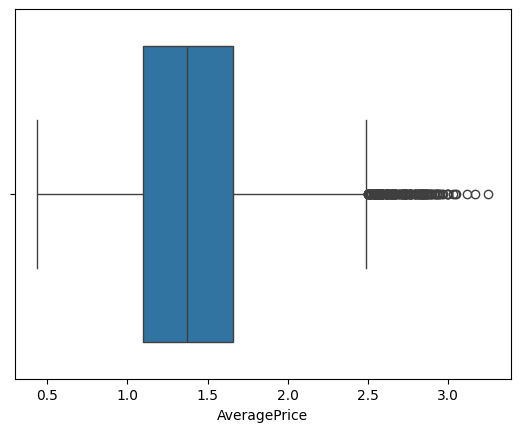

In [43]:
sns.boxplot(x=df_avocados["AveragePrice"])

<Axes: xlabel='Total Volume'>

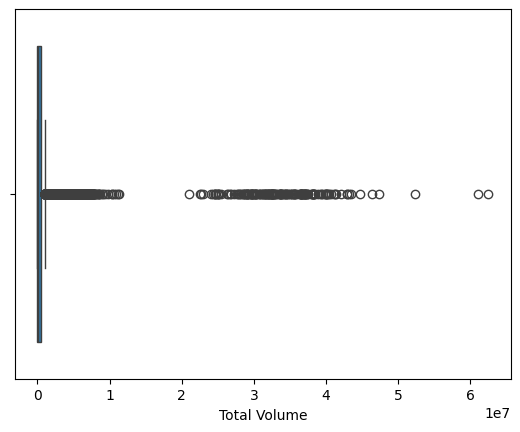

In [44]:
sns.boxplot(x=df_avocados["Total Volume"])

**Observation**

As we can see there are a LOT of outliers, especially in the volume column. So dealing with outliers was and will be the main reason of this project!

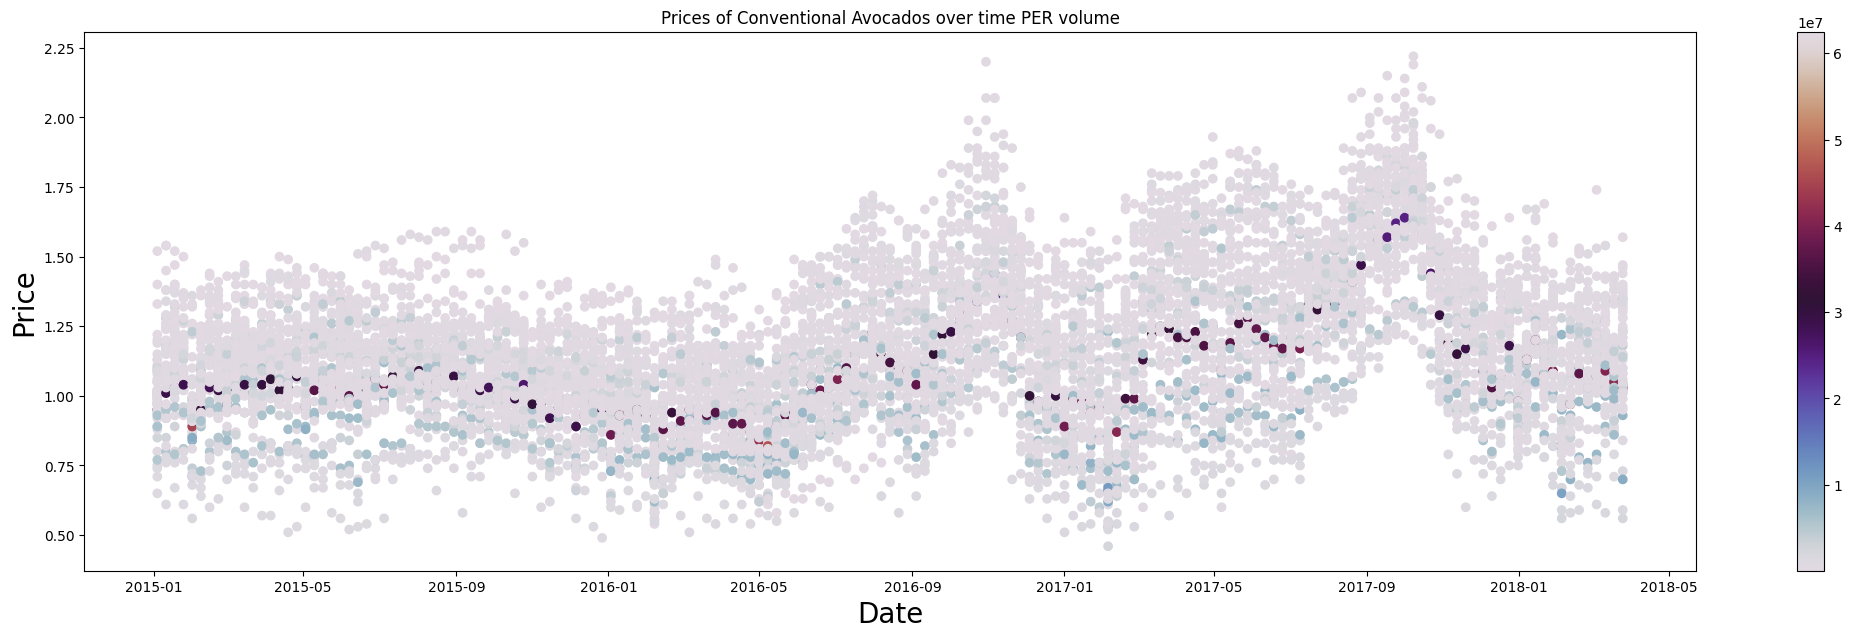

In [45]:
# Checking the prices of conventional avocados

conventional_avocados = df_avocados["type"]== "conventional"
organic_avocados = df_avocados["type"]== "organic"

# fig, ax = plt.subplots(2, 1, figsize=(10, 8), dpi=120)
fig = plt.figure(figsize = (26, 7))


# Data - CONVENTIONAL
dates_conventional = df_avocados[conventional_avocados]["Date"].tolist()
average_prices_conventional = df_avocados[conventional_avocados]["AveragePrice"].tolist()
total_volume_conventional = df_avocados[conventional_avocados]["Total Volume"]

# Data - ORGANIC
dates_organic = df_avocados[organic_avocados]["Date"].tolist()
average_prices_organic = df_avocados[organic_avocados]["AveragePrice"].tolist()
total_volume_organic = df_avocados[organic_avocados]["Total Volume"]


# Plot
plt.scatter(dates_conventional, average_prices_conventional, c=total_volume_conventional, cmap="twilight")
plt.colorbar()
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.title("Prices of Conventional Avocados over time PER volume")
plt.show()

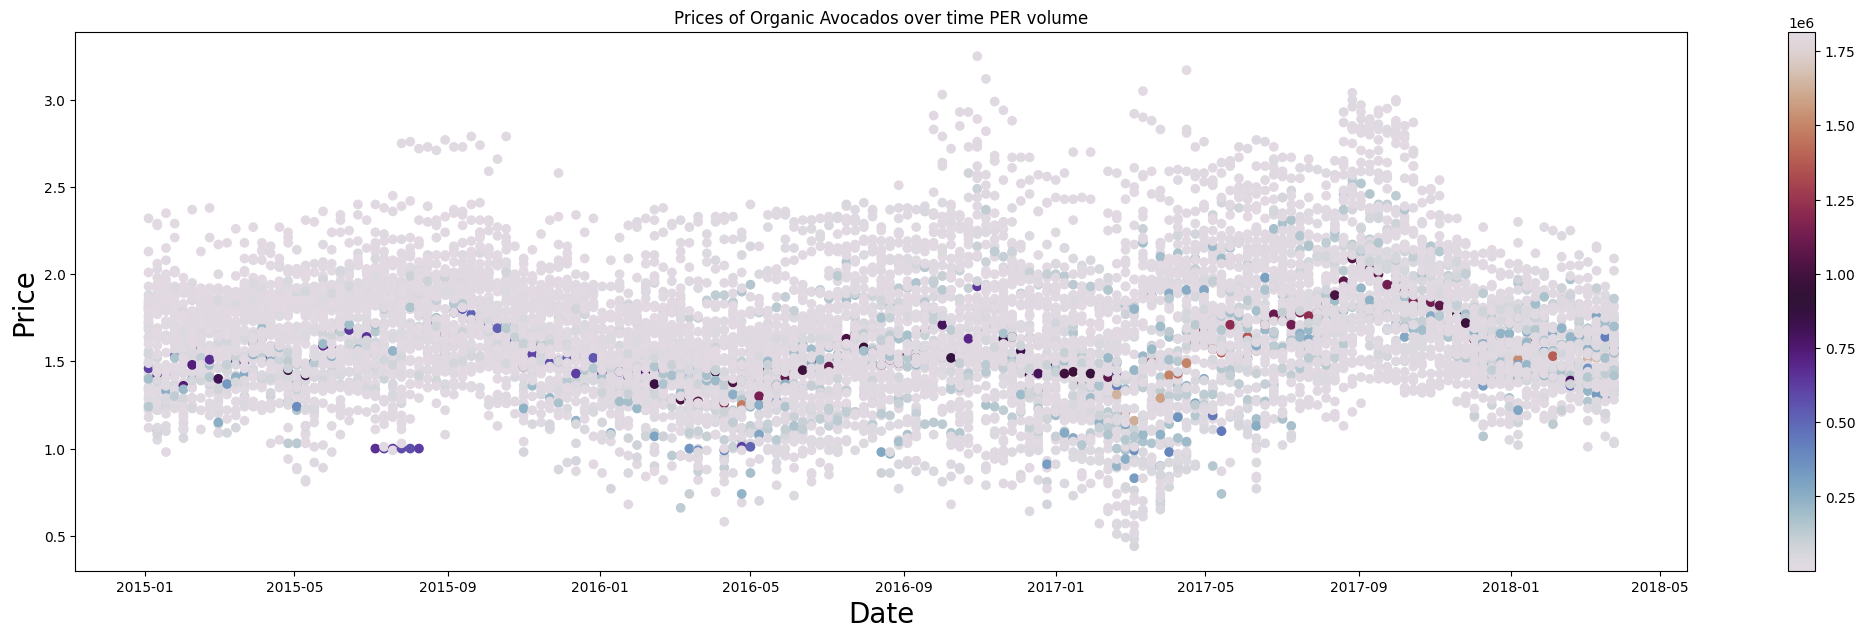

In [46]:
fig = plt.figure(figsize = (26, 7))
plt.scatter(dates_organic, average_prices_organic, c=total_volume_organic, cmap="twilight")
plt.colorbar()
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.title("Prices of Organic Avocados over time PER volume")
plt.show()

In [47]:
df_avocados.region.value_counts()

region
Southeast              338
NewOrleansMobile       338
SanDiego               338
BaltimoreWashington    338
Roanoke                338
RichmondNorfolk        338
Northeast              338
SouthCentral           338
GreatLakes             338
Louisville             338
Seattle                338
CincinnatiDayton       338
NewYork                338
Indianapolis           338
Chicago                338
Jacksonville           338
Columbus               338
Detroit                338
Philadelphia           338
PhoenixTucson          338
Nashville              338
Portland               338
HartfordSpringfield    338
Tampa                  338
Orlando                338
West                   338
Denver                 338
GrandRapids            338
NorthernNewEngland     338
BuffaloRochester       338
HarrisburgScranton     338
Pittsburgh             338
Boise                  338
LosAngeles             338
LasVegas               338
Atlanta                338
DallasFtWorth        

In [48]:
df_avocados.region.unique()

array(['Southeast', 'Chicago', 'HarrisburgScranton', 'Pittsburgh',
       'Boise', 'WestTexNewMexico', 'LosAngeles', 'LasVegas', 'Atlanta',
       'DallasFtWorth', 'MiamiFtLauderdale', 'Plains', 'StLouis',
       'Syracuse', 'Midsouth', 'Sacramento', 'Boston', 'Charlotte',
       'Spokane', 'Albany', 'Houston', 'SouthCarolina', 'SanFrancisco',
       'TotalUS', 'RaleighGreensboro', 'BuffaloRochester',
       'NorthernNewEngland', 'GrandRapids', 'Denver', 'SanDiego',
       'BaltimoreWashington', 'Roanoke', 'RichmondNorfolk', 'Northeast',
       'SouthCentral', 'GreatLakes', 'Louisville', 'Seattle',
       'CincinnatiDayton', 'NewYork', 'NewOrleansMobile', 'Indianapolis',
       'Jacksonville', 'Columbus', 'Detroit', 'Philadelphia',
       'PhoenixTucson', 'Nashville', 'Portland', 'HartfordSpringfield',
       'Tampa', 'Orlando', 'West', 'California'], dtype=object)

In [49]:
# Basically we can remove states and work on cities rather than analysing both (to prevent multicollinerarity)

regions_to_remove = ['California', 'GreatLakes', 'Midsouth', 'NewYork', 'Northeast', 'SouthCarolina', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West']
df_avocados = df_avocados[~df_avocados.region.isin(regions_to_remove)]
len(df_avocados.region.unique())

43

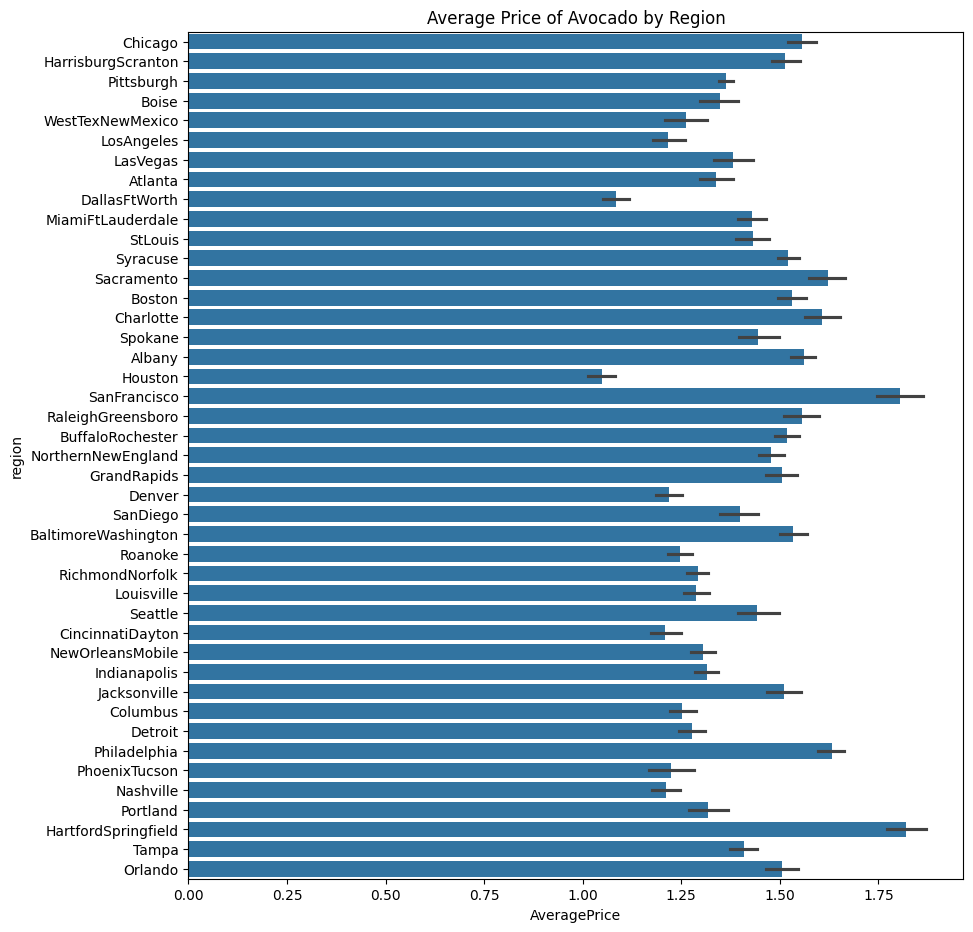

In [50]:
# The average prices by regions
plt.figure(figsize=(10,11))
plt.title("Average Price of Avocado by Region")
sns.barplot(y="region",x="AveragePrice", data= df_avocados)
plt.show()

# **Pre-Processing**
In this section, we'll deal with some things in our data and make it useable with Machine Learning. We'll do the following


*   Deal with Null (NAN) values
*   OneHotEncoding ***pd.get_dummies()***
*   Scaling RobustScaler
*   PCA *Principal Component Analysis*
*   Deal with Outliers

In [51]:
# Check for NULL values
df_avocados.isna().sum()

Date            0
Total Volume    0
Small Hass      0
Large Hass      0
XLarge Hass     0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
AveragePrice    0
dtype: int64

Oh well, that's good. No **NULL** values. So nothing to fix here. Let's One Hot Encode the values via ***pd.dummies()***

In [52]:
# Note: I'm using pd.get_dummies as it is quicker as my main focus is towards dealing with Outliers (THIS SHOULD NOT BE USED IN PRODUCTION LEVEL CODE)
df_avocados.drop(columns="Date", inplace=True)
df_avocados = pd.get_dummies(df_avocados, drop_first=True)
df_avocados.shape

(14531, 53)

In [53]:
# Scaling via RobustScaler
robust_scaler = RobustScaler()
robust_scaler.fit(df_avocados)
robust_scaler.transform(df_avocados);

In [54]:
# Applying PCA
pca = PCA(n_components=2)
pca.fit(df_avocados)

# Some PCA stats
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.90395013 0.04866989]
[60396065.58409765 14014145.24368097]


In [55]:
df_avocados

,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,year,AveragePrice,...,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_WestTexNewMexico
1,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,2015,1.49,...,False,False,False,False,False,False,False,False,False,False
2,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,2015,1.68,...,False,False,False,False,False,False,False,False,False,False
3,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,2015,1.52,...,False,False,False,False,False,False,False,False,False,False
4,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,2015,1.64,...,False,False,False,False,False,False,False,False,False,False
5,758118.95,426878.87,147958.43,15267.89,168013.76,165202.22,2811.54,0.00,2015,0.75,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18240,5518.73,171.22,806.65,3.93,4536.93,2944.89,1592.04,0.00,2018,1.75,...,False,False,False,False,False,False,False,False,False,False
18241,17340.49,295.16,3478.97,81.25,13485.11,12149.49,1335.62,0.00,2018,1.42,...,False,False,False,False,False,False,False,False,False,False
18242,429132.50,258217.83,25970.97,1426.07,143517.63,90870.28,52357.35,290.00,2018,1.32,...,False,False,False,False,False,False,False,False,False,False
18243,38441.23,27.25,2031.54,0.00,36382.44,29466.95,6915.49,0.00,2018,1.74,...,False,False,False,False,False,False,False,False,False,False


In [56]:
import warnings
warnings.filterwarnings("ignore")

def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

df_avocados = cap_data(df_avocados)

<Axes: xlabel='Total Volume'>

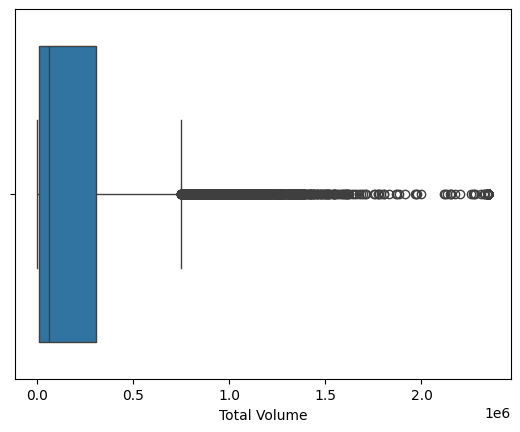

In [57]:
sns.boxplot(x=df_avocados["Total Volume"])

Well now our data is free of outliers and we can move to the modelling section of our project.

# **Modelling**
In this part, we'll train our ML model to predict the average price of the avocados. We'll be using the following algorithms:

*   Random Forest
*   Linear Regression

*   XGBoost (Best for Outliers)

Also, I'll use decision trees to get Feature Importance

In [58]:
df_avocados.head(1)

,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,year,AveragePrice,...,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_WestTexNewMexico
1,17723.17,1189.35,15628.27,0.0,905.55,905.55,0.0,0.0,2015,1.49,...,False,False,False,False,False,False,False,False,False,False


In [59]:
# Set the features and targets
features = df_avocados.drop(columns="AveragePrice")
target = df_avocados.AveragePrice

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [60]:
# Feature Importance
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
round(model_dt.score(X_test, y_test), 2) * 100

72.0

In [61]:
y_test.shape

(2907,)

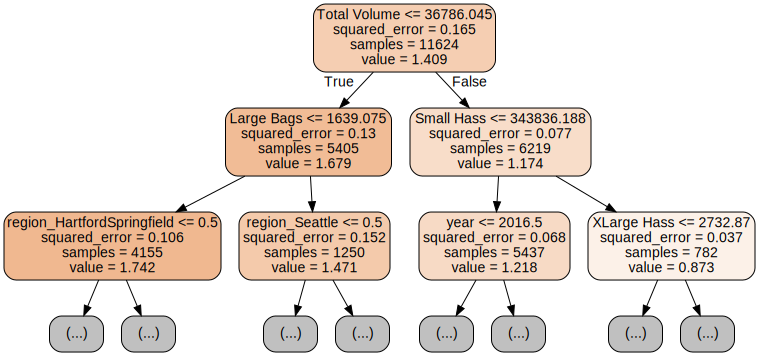

<Figure size 1000x800 with 0 Axes>

In [62]:
from sklearn import tree
import graphviz
plt.figure(figsize=(10, 8))
dot_data = tree.export_graphviz(model_dt, max_depth=2, filled=True, rounded=True, feature_names=df_avocados.columns.drop("AveragePrice"));
graph = graphviz.Source(dot_data)
graph

Imporant Columns are:

*   Total Volume
*   Large Bags & Small Hass
*   Seattle and Hartford are 2 prominent regions
*   Year
*   Hass (XLarge)

In [63]:
# Traing the other 3 models
modelclasses = [
    ["Linear Regression", LinearRegression()],
    ["Decision Tree Regressor", DecisionTreeRegressor()],
    ["Random Forest Regressor", RandomForestRegressor()],
    ["XGBoost Regressor", XGBRegressor()]
]

insights = []
for modelname, Model in modelclasses:
    model = Model
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    insights.append((modelname, score))

In [64]:
insights.sort(key=lambda x:x[-1], reverse=True)
insights

pd.DataFrame(insights, columns=["Model Name", "Score"])

,Model Name,Score
0,Random Forest Regressor,0.861352
1,XGBoost Regressor,0.852360
2,Decision Tree Regressor,0.729471
3,Linear Regression,0.549135


And there we go, our model results are out! The best seems to be the Random Forest followed by XGboost.